In [1]:
from os.path import join
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn.functional as F
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from IPython.display import display, clear_output
from pycocotools.coco import COCO


from torchmetrics.classification import MulticlassJaccardIndex
import time

# Load the COCO 2017 test set
coco = COCO('/home/samyakr2/multilabel/data/coco/annotations/instances_val2017.json')
image_dir = '/home/samyakr2/multilabel/data/coco/val2017/'

device = "cuda" if torch.cuda.is_available() else "cpu"


voc_classes_background = [ "background",
    "aeroplane", "bicycle", "bird", "boat", "bottle", 
    "bus", "car", "cat", "chair", "cow", 
    "dining table", "dog", "horse", "motorbike", "person", 
    "potted plant", "sheep", "sofa", "train", "tv/monitor"
]


coco_classnames = ['background',"person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                           "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
                           "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
                           "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
                           "kite",
                           "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
                           "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich",
                           "orange",
                           "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
                           "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
                           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                           "teddy bear", "hair drier", "toothbrush"]



model, _ = clip.load("RN101", device=device)
preprocess_img =  Compose([Resize((448, 448), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

preprocess_target =  Compose([ToTensor()])

all_texts = voc_classes_background[1:]
# all_texts = coco_classnames[1:]

with torch.no_grad():
    text_feats = clip.encode_text_with_prompt_ensemble(model, all_texts, device, prompt_templates = ['a photo of a {}.'])

text_feats = F.normalize(text_feats, dim=-1) 


matrix = torch.matmul(text_feats, text_feats.T) 


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


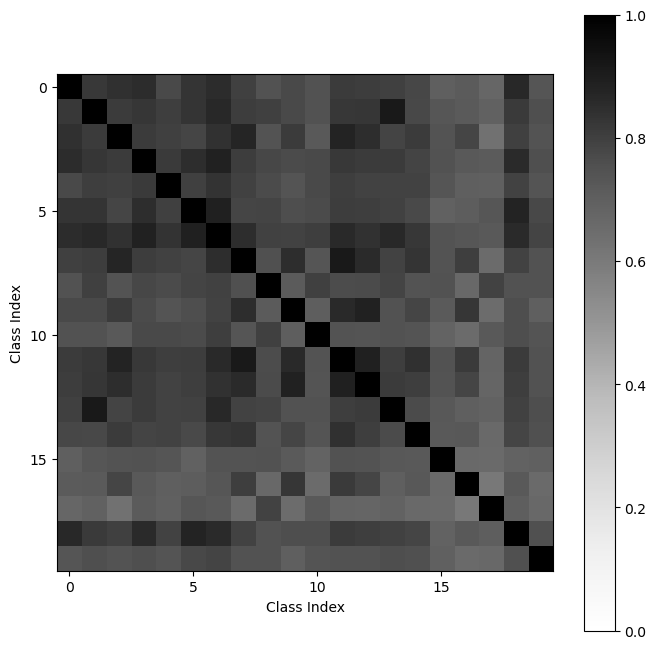

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a random 20x20 matrix
# matrix = np.random.rand(20, 20)  # Values between 0 and 1
if matrix.min() < 0:
    normalized_matrix  = (matrix - matrix.min()) / (matrix.max() - matrix.min())
else: normalized_matrix = matrix
matrix_plot = normalized_matrix.detach().cpu()
# Plot the matrix as a color-coded image
fixed_vmin = 0.0  # Minimum value for the color scale
fixed_vmax = 1.0 
plt.figure(figsize=(8, 8))
plt.imshow(matrix_plot, cmap='Greys', interpolation='nearest', vmin=fixed_vmin, vmax=fixed_vmax)
plt.colorbar(label='')
# plt.title("Color-coded Representation of a 20x20 Matrix")
plt.xlabel("Class Index")
plt.ylabel("Class Index")
plt.xticks(ticks=np.arange(0, matrix.shape[1], 5), labels=np.arange(0, matrix.shape[1], 5).astype(int))
plt.yticks(ticks=np.arange(0, matrix.shape[0], 5), labels=np.arange(0, matrix.shape[0], 5).astype(int))

plt.show()



In [3]:
print(matrix_plot.min())
matrix_plot.max()


tensor(0.6035)


tensor(1.0000)

## Text Projector

In [4]:
import torch.nn as nn
import torch.nn.functional as F


model, _ = clip.load("RN101", device=device)
model.eval()


sizes = [512, 384, 256]

# sizes = [1024, 768, 512] ## RN50

layers_text = []
for i in range(len(sizes) - 2):
    layers_text.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
    layers_text.append(nn.BatchNorm1d(sizes[i + 1]))
    layers_text.append(nn.ReLU(inplace=True))
layers_text.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
text_projector = nn.Sequential(*layers_text).to(device)


# model_path = '/home/samyakr2/Redundancy/DualCoOp/output/voc2007-DualCoop-RN101SSL_posneg_p1.0-0.05R/model_best.pth.tar'
model_path = '/home/samyakr2/Redundancy/DualCoOp/output/coco_RN101_SSL_90_0.002R/model_best.pth.tar'
# model_path = '/home/samyakr2/CLIP_Surgery/weights_coco/RN101_0.005.pth.tar'
# model_path = '/home/samyakr2/CLIP_Surgery/weights_coco/RN50_coco_0.012_goat.pth.tar'

state_dict = torch.load(model_path)

projector_weights_text = {}
projector_weights_img = {}

for kays in state_dict['state_dict'].keys():
    if 'text_projector' in kays:
        projector_weights_text[kays[15:]] = state_dict['state_dict'][kays]


text_projector.load_state_dict(projector_weights_text)

<All keys matched successfully>

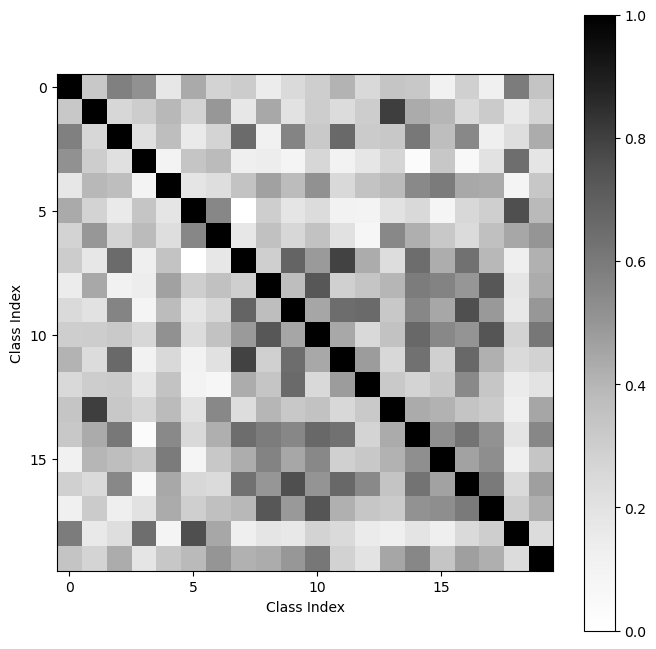

In [5]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    text_feats = clip.encode_text_with_prompt_ensemble(model, all_texts, device, prompt_templates = ['a photo of a {}.'])
    text_feats = F.normalize(text_feats, dim=-1) 
    


projected_text = text_projector(text_feats)
projected_text = F.normalize(projected_text, dim=-1) 

matrix = torch.matmul(projected_text, projected_text.T) 

if matrix.min() < 0:
    normalized_matrix  = (matrix - matrix.min()) / (matrix.max() - matrix.min())
else: normalized_matrix = matrix
matrix_plot = normalized_matrix.detach().cpu()

fixed_vmin = 0.0  # Minimum value for the color scale
fixed_vmax = 1.0 
plt.figure(figsize=(8, 8))
plt.imshow(matrix_plot, cmap='Greys', interpolation='nearest', vmin=fixed_vmin, vmax=fixed_vmax)
plt.colorbar(label='')
# plt.title("Color-coded Representation of a 20x20 Matrix")
plt.xlabel("Class Index")
plt.ylabel("Class Index")

plt.xticks(ticks=np.arange(0, matrix.shape[1], 5), labels=np.arange(0, matrix.shape[1], 5).astype(int))
plt.yticks(ticks=np.arange(0, matrix.shape[0], 5), labels=np.arange(0, matrix.shape[0], 5).astype(int))

plt.show()



In [6]:
print(matrix_plot.min())
matrix_plot.max()

tensor(0.)


tensor(1.)

In [7]:
text_feats.min()

tensor(-0.5854, device='cuda:0')